**Nama : Geraldus Jeremy Chandra**

**NIM : 2702368236**

**TUJUAN**

Di soal ini tujuannya adalah untuk membandingkan 3 model GAN dengan FID sebagai acuannya. Ada 3 model yang akan dibandingkan, yaitu model baseline, model baseline yang dimodify manual, dan model baseline yang dimodify dengan hyperparameter tuning.  EDA tidak saya ulang karena sama seperti di no 2 sehingga saya langsung masuk ke modelling. Di soal ini dimension utnuk latent noise vectornya saya asumsikan 100 sama seperti soal sebelumnya.

In [ ]:
!unzip A_23-20250626T100121Z-1-001.zip

Archive:  A_23-20250626T100121Z-1-001.zip
  inflating: A_23/siirt 9.jpg        
  inflating: A_23/siirt 90.jpg       
  inflating: A_23/siirt 96.jpg       
  inflating: A_23/siirt 80.jpg       
  inflating: A_23/siirt 87.jpg       
  inflating: A_23/siirt 76.jpg       
  inflating: A_23/siirt 74.jpg       
  inflating: A_23/siirt 86.jpg       
  inflating: A_23/siirt 95.jpg       
  inflating: A_23/siirt 81.jpg       
  inflating: A_23/siirt 93.jpg       
  inflating: A_23/siirt 89.jpg       
  inflating: A_23/siirt 94.jpg       
  inflating: A_23/siirt 77.jpg       
  inflating: A_23/siirt 85.jpg       
  inflating: A_23/siirt 75.jpg       
  inflating: A_23/siirt 82.jpg       
  inflating: A_23/siirt 91.jpg       
  inflating: A_23/siirt 84.jpg       
  inflating: A_23/siirt 99.jpg       
  inflating: A_23/siirt 83.jpg       
  inflating: A_23/siirt 92.jpg       
  inflating: A_23/siirt 98.jpg       
  inflating: A_23/siirt 8.jpg        
  inflating: A_23/siirt 79.jpg       
  inflat

**IMPORT LIBRARY**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from IPython import display
from tqdm import tqdm
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
folder_path = '/content/A_23/'
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

In [ ]:
IMAGE_SIZE = 100
BATCH_SIZE = 64

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = (image - 127.5) / 127.5
    return image

set image size dan batch sizenya. batch yang lebih besar biasanya lebih stabil untuk GAN. Lalu function untuk read filenya dan melakukan proses normalisasi range gambarnya jadi [-1,1] karnea generator menggunakan activation tanh.

In [ ]:
NUM_FID_IMAGES = 100
np.random.shuffle(image_files)
train_files = image_files[:-NUM_FID_IMAGES]
test_files = image_files[-NUM_FID_IMAGES:]

In [ ]:
X_test = np.array([load_and_preprocess_image(f).numpy() for f in test_files])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(image_files).shuffle(len(image_files)).map(load_and_preprocess_image).batch(BATCH_SIZE)

membuat dataset tensorflow

In [ ]:
NOISE_DIM = 100
EPOCHS = 2000

set latent noice dimensionnya menjadi 100 (kita asumsikan) dan epoch 100

**MODELLING**

In [ ]:
def build_generator():
    noise_input = layers.Input(shape=(NOISE_DIM,))

    x = layers.Dense(25 * 25 * 64, use_bias=False)(noise_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((25, 25, 64))(x)

    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    image_output = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

    model = Model(inputs=noise_input, outputs=image_output)
    return model

generator = build_generator()
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40000)          │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40000)          │       160,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 50, 50, 32)     │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 100, 100, 16)   │         4,608 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 100, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 100, 100, 3)    │           432 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,183,664 (15.96 MB)

 Trainable params: 4,103,568 (15.65 MB)

 Non-trainable params: 80,096 (312.88 KB)

Function generator menerima input vektor noise acak. lalu vektor ini pertama kali diproyeksikan dan diubah bentuknya menjadi semacam feature map dengan layer dense dan reshape. lalu diset rangkaian layer conv2Dtranspose secara bertahap upscaling feature mapnya sambil dia akan mempelajari pola-pola visual yang kompleks. Hingga akhirnya akan menghasilkan gambar dengan ukuran 100x100x3. Sesuai soal juga diminta activation function tanh di layer paling terakhir yang memastikan nilai pixelnya berada di rentang [-1,1] sesuai normalization data gambar asli.

In [ ]:
def build_discriminator():
    image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='valid')(image_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='valid')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='valid')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=image_input, outputs=x)
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 565504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       565,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 589,089 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

Untuk discriminator arstitektuirnya berupa model klasifikasi gambar standar yang menggunakan beberapa layer conv2d untuk extracting feature penting dari input gambarnya. Hasil extractionnya bakal diflattened menjadi satu vektor dan dimasukkan ke sebuah later dense dengan activation sigmoid. Output yang dihasilkan berupa nilai 0 dan 1 menjadi penentu gambar yang dievaluasi asli atau tidak.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

menggunakan binarycrossentropy sebagai loss function karena discriminator merupakan klasifikasi biner. optimizer mengunakan adam karena efisien untuk adaptasi learning rate seara otomatis. hal ini membantu menstabilkan training gan yang komplek dan sesitif dengan nilai learning ratenya.

Epoch 2000/2000


100%|██████████| 17/17 [00:00<00:00, 36.87it/s]


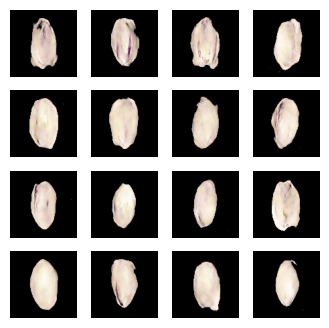

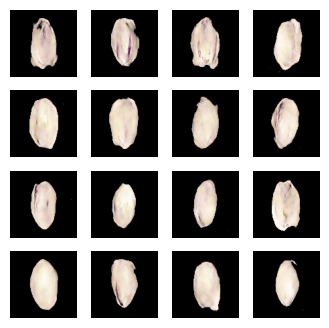

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

def train(dataset, epochs):
    seed = tf.random.normal([16, NOISE_DIM])

    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        display.clear_output(wait=True)
        print(f"Epoch {epoch + 1}/{epochs}")

        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in tqdm(dataset):
            g_loss, d_loss = train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)

        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))

        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

    generate_and_save_images(generator, epochs, seed)

    return gen_losses, disc_losses

gen_losses, disc_losses = train(train_dataset, EPOCHS)

Looping dibuat untuk training GAN karena melibatkan 2 model yang dilatih secara bergantian, sehingga tidak bisa asal menggunakan model.fit. di setiap stepnya, discriminator akan dilatih dengan satu batch gambar asli (dilabeli 1)dan satu batch gambar palsu yang dibuat oleh generator (dilabeli 0) agar mempelajari membedekan asli dan palsu. lalu generator dilatih agar menipu discriminator. generator mencoba terus untuk membuat gambar palsu yang membuat diskriminator classify itu sebagai gambar asli. di proses ini bobot discriminator bakal diberhentiin sejenak dan generator diperbarui terus. dan bakal terus seperti itu seolah-olah saling bersaing untuk push generator menghasilkan gambar yang semakin realistis untuk menipu diskriminator dan diskriminator juga samkin ahli membedakannya.

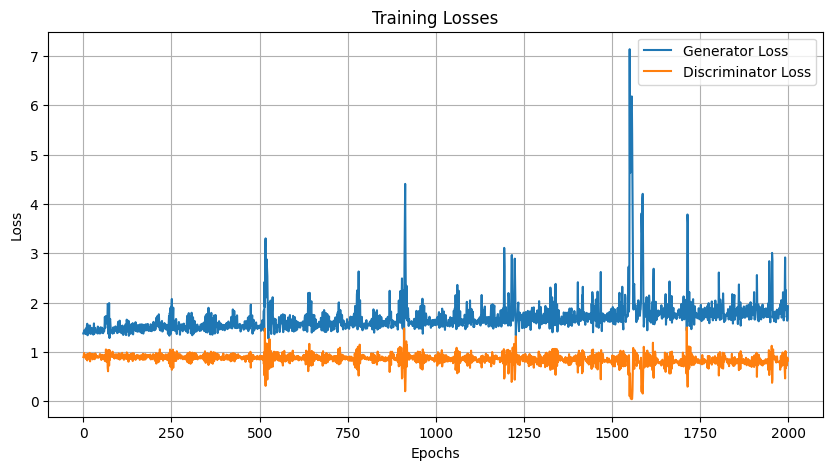

In [ ]:
# Plot training losses
plt.figure(figsize=(10,5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

secara garis besar, model baseline yang dilatih selama 2000 epoch ini menunjukkan gambaran training GAN yang matang namun tetap menyoroti keterbatasan arsitektur dasarnya. Namun, aspek kritisnya adalah tingginya volatilitas dan adanya lonjakan loss pada Generator secara periodik. Kestabilan yang belum sepenuhnya tercapai ini menyiratkan bahwa meskipun model sudah dilatih lama, arsitektur baseline yang sederhana ini kesulitan untuk secara konsisten menghasilkan gambar berkualitas tinggi dan beragam.

**MODIFIED MODEL**

In [ ]:
def build_manual_generator():
    noise_input = layers.Input(shape=(NOISE_DIM,))

    x = layers.Dense(25 * 25 * 128, use_bias=False)(noise_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((25, 25, 128))(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    image_output = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

    model = models.Model(inputs=noise_input, outputs=image_output)
    return model

manual_generator = build_manual_generator()
manual_generator.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80000)          │     8,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80000)          │       320,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 50, 50, 64)     │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 32)   │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 100, 100, 3)    │           864 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,413,408 (32.09 MB)

 Trainable params: 8,253,216 (31.48 MB)

 Non-trainable params: 160,192 (625.75 KB)

Perbedaan dengan sebelumnya adalah jumlah filter di setiap lapisan dense dan conv2dtranspose ditingkatkan agar model mempelajari fitur yang lebih kaya dan lebih detail. activation function ReLU diubah menjadi LeakyRELU dengan harapan untuk mengatasi masalah dying neurons pada GAN, ditambah lapisan BatchNormalization untuk setiap convoloution agar proses lebih stabil dan convergence lebih cepat.

In [ ]:
def build_manual_discriminator():
    image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='valid')(image_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='valid')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='valid')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=image_input, outputs=x)
    return model

manual_discriminator = build_manual_discriminator()
manual_discriminator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 565504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │       565,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 589,089 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

Untuk discriminatornya yang dubah berfokus pada regularisasinya dalam tujuan untuk mencegah terlalu dominan. dropout ditingkatkan dari 0.3 menjadi 0.4 dalam upayanya mengurangi resikon overfitting pada data training dan mendorong diskriminator belajar fitur yang lebih general sekedar menghafal. Activation relu juga diganti menjadi leakyrelu untuk aliran gradien yang lebih baik untuk memberikan feedback bagus kepada generator

Training Manual Model - Epoch 2000/2000


100%|██████████| 17/17 [00:00<00:00, 31.50it/s]


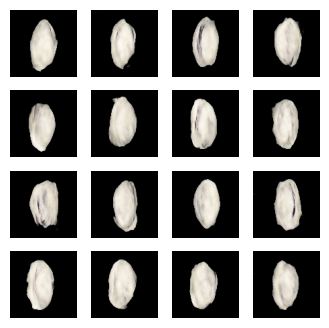

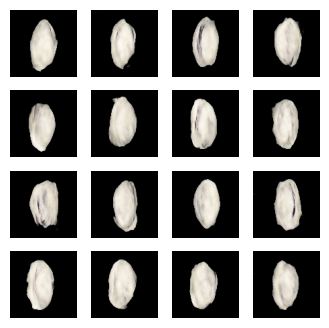

In [ ]:
manual_generator_optimizer = tf.keras.optimizers.Adam(1e-4)
manual_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def manual_train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = manual_generator(noise, training=True)

        real_output = manual_discriminator(images, training=True)
        fake_output = manual_discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, manual_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, manual_discriminator.trainable_variables)

    manual_generator_optimizer.apply_gradients(zip(gradients_of_generator, manual_generator.trainable_variables))
    manual_discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, manual_discriminator.trainable_variables))

    return gen_loss, disc_loss

def train_manual_model(dataset, epochs):
    seed = tf.random.normal([16, NOISE_DIM])
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        display.clear_output(wait=True)
        print(f"Training Manual Model - Epoch {epoch + 1}/{epochs}")

        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in tqdm(dataset):
            g_loss, d_loss = manual_train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)

        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(manual_generator, epoch + 1, seed)

    generate_and_save_images(manual_generator, epochs, seed)
    return gen_losses, disc_losses

gen_losses_manual, disc_losses_manual = train_manual_model(train_dataset, EPOCHS)

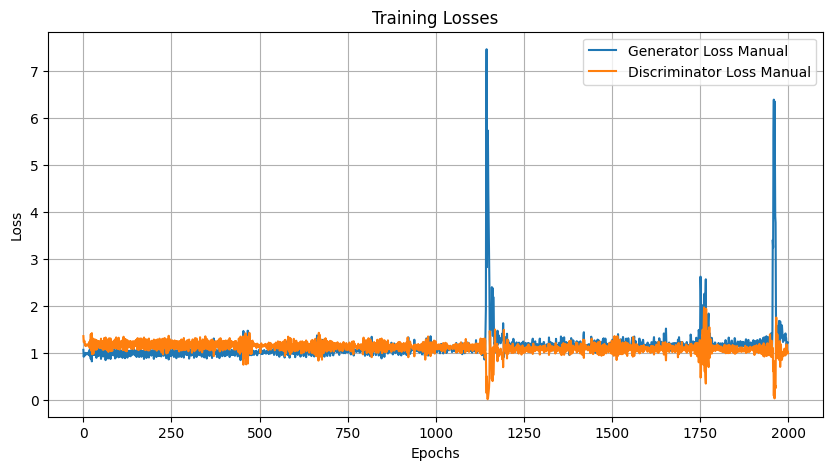

In [ ]:
# Plot training losses
plt.figure(figsize=(10,5))
plt.plot(gen_losses_manual, label='Generator Loss Manual')
plt.plot(disc_losses_manual, label='Discriminator Loss Manual')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Plot loss yang kedua untuk model yang dimodifikasi manual menghasilkan training yang lebih bagus. ekuilibrium antara generator dan discriminator lebih stabil dibandingkan sebelumnya. namun masih rentan dengna shock yang membuat kegagalan sesaat yang masih sama ekstrimnya dengan model sebelumnya di kisaran epocj ke 1100 dan 1900. model ini bergerak cukup rapat di nilai sekitar 1 yang menunjukan regularisasinya lebih seimbang.

**TUNING MODIFIED MODEL**

In [ ]:
hp_combinations = [
    {'id': 1, 'gen_lr': 2e-4, 'disc_lr': 2e-4, 'dropout': 0.4},
    {'id': 2, 'gen_lr': 1e-4, 'disc_lr': 1e-4, 'dropout': 0.4},
    {'id': 3, 'gen_lr': 2e-4, 'disc_lr': 1e-4, 'dropout': 0.5},
    {'id': 4, 'gen_lr': 1e-4, 'disc_lr': 2e-4, 'dropout': 0.5},
]

tuning_results = {}
SEARCH_EPOCHS = 20

defining 4 kombinasi hyperparameter untuk memperbagus stabilitas GANnya, learning rate untuk generator dan diskriminator, dropoutrate untuk discriminator.

In [ ]:
def build_model_for_tuning(hp):
    gen_input = layers.Input(shape=(NOISE_DIM,))
    x = layers.Dense(25 * 25 * 128, use_bias=False)(gen_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((25, 25, 128))(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    gen_output = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    generator = models.Model(inputs=gen_input, outputs=gen_output)

    disc_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='valid')(disc_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(hp['dropout'])(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='valid')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(hp['dropout'])(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='valid')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(hp['dropout'])(x)
    x = layers.Flatten()(x)
    disc_output = layers.Dense(1, activation='sigmoid')(x)
    discriminator = models.Model(inputs=disc_input, outputs=disc_output)

    return generator, discriminator



In [ ]:
for hp in hp_combinations:
    print(f"--- Menguji Kombinasi #{hp['id']}: {hp} ---")

    temp_generator, temp_discriminator = build_model_for_tuning(hp)

    temp_gen_optimizer = tf.keras.optimizers.Adam(learning_rate=hp['gen_lr'])
    temp_disc_optimizer = tf.keras.optimizers.Adam(learning_rate=hp['disc_lr'])

    last_gen_loss = 0
    for epoch in range(SEARCH_EPOCHS):
        for image_batch in train_dataset:
            noise = tf.random.normal([image_batch.shape[0], NOISE_DIM])
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = temp_generator(noise, training=True)
                real_output = temp_discriminator(image_batch, training=True)
                fake_output = temp_discriminator(generated_images, training=True)
                gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
                disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)
            gradients_of_generator = gen_tape.gradient(gen_loss, temp_generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, temp_discriminator.trainable_variables)
            temp_gen_optimizer.apply_gradients(zip(gradients_of_generator, temp_generator.trainable_variables))
            temp_disc_optimizer.apply_gradients(zip(gradients_of_discriminator, temp_discriminator.trainable_variables))
            last_gen_loss = gen_loss.numpy()

    tuning_results[hp['id']] = last_gen_loss
    print(f"--- Selesai Kombinasi #{hp['id']}. Final Generator Loss: {last_gen_loss:.4f} ---\n")

print("--- Hasil Pencarian Hyperparameter ---")
for hp_id, loss in tuning_results.items():
    print(f"Kombinasi #{hp_id}: Loss = {loss:.4f}")

--- Menguji Kombinasi #1: {'id': 1, 'gen_lr': 0.0002, 'disc_lr': 0.0002, 'dropout': 0.4} ---
--- Selesai Kombinasi #1. Final Generator Loss: 1.8780 ---

--- Menguji Kombinasi #2: {'id': 2, 'gen_lr': 0.0001, 'disc_lr': 0.0001, 'dropout': 0.4} ---
--- Selesai Kombinasi #2. Final Generator Loss: 8.9114 ---

--- Menguji Kombinasi #3: {'id': 3, 'gen_lr': 0.0002, 'disc_lr': 0.0001, 'dropout': 0.5} ---
--- Selesai Kombinasi #3. Final Generator Loss: 1.7538 ---

--- Menguji Kombinasi #4: {'id': 4, 'gen_lr': 0.0001, 'disc_lr': 0.0002, 'dropout': 0.5} ---
--- Selesai Kombinasi #4. Final Generator Loss: 13.3700 ---

--- Hasil Pencarian Hyperparameter ---
Kombinasi #1: Loss = 1.8780
Kombinasi #2: Loss = 8.9114
Kombinasi #3: Loss = 1.7538
Kombinasi #4: Loss = 13.3700


membuat looping untuk menguji setiap kombinasi yang kita punya(4). mencatat loss generator terkahir setiap percobaan untuk menjadi pembanding konfigurasi mana yang paling bagus.

Training Final Tuned Model - Epoch 2000/2000


100%|██████████| 17/17 [00:00<00:00, 31.54it/s]


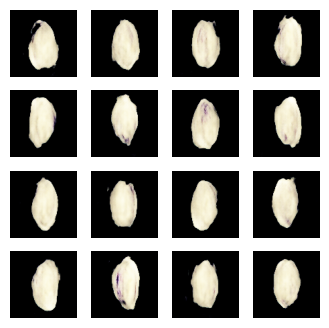

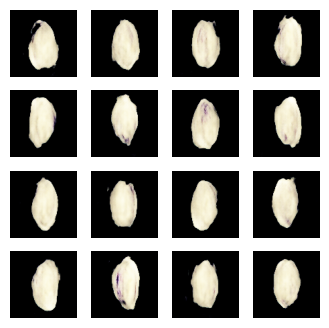

In [ ]:
best_hp_id = min(tuning_results, key=tuning_results.get)
best_hp = next((item for item in hp_combinations if item["id"] == best_hp_id), None)

print(f"\n--- Konfigurasi Hyperparameter Terbaik Ditemukan: Kombinasi #{best_hp_id} ---")
print(best_hp)

tuned_generator, tuned_discriminator = build_model_for_tuning(best_hp)

tuned_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=best_hp['gen_lr'])
tuned_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=best_hp['disc_lr'])

@tf.function
def tuned_train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = tuned_generator(noise, training=True)
        real_output = tuned_discriminator(images, training=True)
        fake_output = tuned_discriminator(generated_images, training=True)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, tuned_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, tuned_discriminator.trainable_variables)
    tuned_generator_optimizer.apply_gradients(zip(gradients_of_generator, tuned_generator.trainable_variables))
    tuned_discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, tuned_discriminator.trainable_variables))
    return gen_loss, disc_loss

def train_tuned_model(dataset, epochs):
    seed = tf.random.normal([16, NOISE_DIM])
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        display.clear_output(wait=True)
        print(f"Training Final Tuned Model - Epoch {epoch + 1}/{epochs}")

        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in tqdm(dataset):
            g_loss, d_loss = tuned_train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)

        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(tuned_generator, epoch + 1, seed)

    generate_and_save_images(tuned_generator, epochs, seed)
    return gen_losses, disc_losses

gen_losses_tuned, disc_losses_tuned = train_tuned_model(train_dataset, EPOCHS)

konfigurasi terbaik ditentukan setelah menganalisis hasil loop pencarian kombinasi yang terbaik berdasarkan loss generator. lalu model baru diset menggunakan hyperparameter tersebut, lalu dilatih seperti sebelumnya

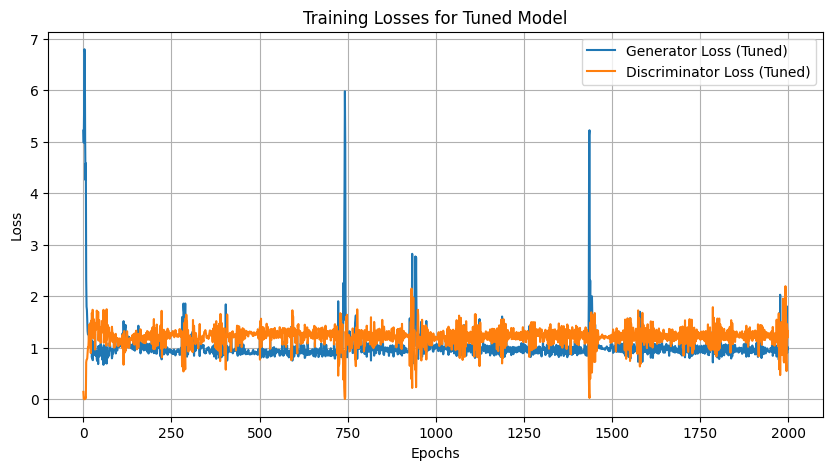

In [ ]:
# Plot training losses untuk model hasil tuning
plt.figure(figsize=(10,5))
plt.plot(gen_losses_tuned, label='Generator Loss (Tuned)')
plt.plot(disc_losses_tuned, label='Discriminator Loss (Tuned)')
plt.title('Training Losses for Tuned Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

dibandingkan model yang sebelumnya, bisa dikatakan model ini memiliki momen kegagalan generator dalam membuat gambar yang baik lebih banyak. namun bisa dikatakan cukup cepat juga untuk kembali on track stabil pulih yang artinnya model responsif untuk mengoreksi dirinya.

In [ ]:
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

def calculate_fid(real_images, generated_images):
    real_images = (real_images * 127.5 + 127.5).astype('uint8')
    generated_images = (generated_images * 127.5 + 127.5).astype('uint8')

    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    act_real = inception_model.predict(real_images)
    act_generated = inception_model.predict(generated_images)

    mu1, sigma1 = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu2, sigma2 = act_generated.mean(axis=0), np.cov(act_generated, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
num_eval_images = len(X_test)

eval_noise = tf.random.normal([num_eval_images, NOISE_DIM])

print("Menghasilkan gambar dari Generator Baseline...")
generated_baseline = generator.predict(eval_noise)

print("Menghasilkan gambar dari Generator Modifikasi Manual...")
generated_manual = manual_generator.predict(eval_noise)

print("Menghasilkan gambar dari Generator Hasil Tuning...")
generated_tuned = tuned_generator.predict(eval_noise)

print("Proses menghasilkan gambar selesai.")

Menghasilkan gambar dari Generator Baseline...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Menghasilkan gambar dari Generator Modifikasi Manual...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Menghasilkan gambar dari Generator Hasil Tuning...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Proses menghasilkan gambar selesai.


In [ ]:
fid_baseline = calculate_fid(X_test, generated_baseline)
fid_manual = calculate_fid(X_test, generated_manual)
fid_tuned = calculate_fid(X_test, generated_tuned)

print("\n--- Hasil Evaluasi FID ---")
print(f"FID Model Baseline: {fid_baseline:.2f}")
print(f"FID Model Modifikasi Manual: {fid_manual:.2f}")
print(f"FID Model Hasil Tuning: {fid_tuned:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

--- Hasil Evaluasi FID ---
FID Model Baseline: 851.61
FID Model Modifikasi Manual: 1158.30
FID Model Hasil Tuning: 1104.50


**PEMBAHASAN HASIL, KESIMPULAN, DAN EVALUASI**

Melihat hasil FIDnya, terlihat bahwa angkanya sangat buruk dan sangat berkebalikan dengan ekpektasi saat melihat lossnya. Model baseline yang dengan FID yang lebih kecil berarti menghasil gambar yang lebih berkualitas dan beragam dibanding kedua model lainnya meskipun loss model yang dimodify lebih baik. Ini merupakan kesalahn fundamental antara tujuan training dan tujuan evaluasi. tujuan awal kita mau membuat gambar yang sebaik mungkin, namun dalam prosesnya, yang mana generator berusaha membuat gambar yang lebih baik itu malah menemukan jalan pintas  untuk menipu discriminator akibat kapasitas filter yang ditambah pada model yang modified. mengakibatkan pada prosesnya terjadi collapse dan menghasilkan variasi yang terbatas dan FID pun sangat buruk.

Untuk meningkatkan hasil, bisa dilakukan augmentasi data seperti horizontal flip atau sedikit rotasi dan zoom untuk memperkaya variasai data trainingnya. modifikasi paling krusial adalah mengubah arsitektur Generator menjadi U-Net dengan skip connections untuk membantu merekonstruksi detail halus yang hilang di bottleneck. Selain itu, menggunakan fungsi loss yang lebih modern seperti Wasserstein Loss dengan Gradient Penalty (WGAN-GP) terbukti jauh lebih stabil dan lebih berkorelasi dengan kualitas gambar dibandingkan Binary Cross-Entropy, sehingga dapat mencegah mode collapse dan secara efektif menurunkan skor FID.

https://drive.google.com/file/d/1_jZHr9f6AXCJadTKOFK_p4mI0E8R8SU9/view?usp=sharing